In [3]:
# -*- coding: utf-8 -*-

# 01-BU

"""

Describe the business objectives here

"""

# 02-DU

# Load Dataset

file = 'WA_Fn-UseC_-Telco-Customer-Churn.xlsx'

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder \
    .appName("ExcelFileReader") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.5") \
    .getOrCreate()
# Read the Excel file
df = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file)
df.show()
# Get the shape of the DataFrame
num_rows = df.count()
num_cols = len(df.columns)
print((num_rows, num_cols))
df.printSchema()
# Convert columns to numeric
df = df.withColumn("MonthlyCharges", col("MonthlyCharges").cast("double"))
df = df.withColumn("TotalCharges", col("TotalCharges").cast("double"))

+----------+------+-------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|ZipCode|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female| 4584.0|          

In [4]:
import pandas as pd
# Convert to pandas DataFrame for better display
pandas_df = df.toPandas()

# Display the pandas DataFrame
display(pandas_df)
pandas_df.info()

,customerID,gender,ZipCode,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,4584.0,0.0,Yes,No,1.0,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,6485.0,0.0,No,No,34.0,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,5423.0,0.0,No,No,2.0,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,9023.0,0.0,No,No,45.0,No,No phone service,DSL,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,2490.0,0.0,No,No,2.0,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,3549.0,0.0,Yes,Yes,24.0,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,6260.0,0.0,Yes,Yes,72.0,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,6333.0,0.0,Yes,Yes,11.0,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,4739.0,1.0,Yes,No,4.0,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   ZipCode           3618 non-null   float64
 3   SeniorCitizen     7043 non-null   float64
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   float64
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7041 non-null   object 
 13  TechSupport       7041 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


+-------+---------------+
|summary|InternetService|
+-------+---------------+
|  count|           7043|
|   mean|           null|
| stddev|           null|
|    min|            DSL|
|    max|             No|
+-------+---------------+

[Row(InternetService='Fiber optic', count=3096), Row(InternetService='No', count=1526), Row(InternetService='DSL', count=2419), Row(InternetService='DSLdsf', count=1), Row(InternetService='DSLdsaf', count=1)]


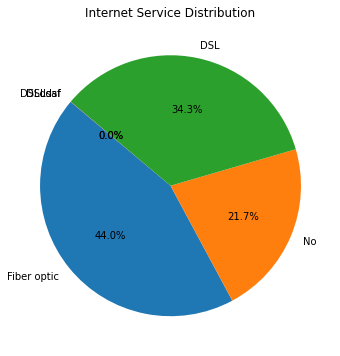

In [5]:
# Explore Data
import matplotlib.pyplot as plt

# Describe the 'InternetService' column
df.select("InternetService").describe().show()

# Get the value counts for 'InternetService'
internet_service_counts = df.groupBy("InternetService").count()
internet_service_counts_df = internet_service_counts.collect()
print(internet_service_counts_df)

# Extract data for plotting
internet_service_labels = [row['InternetService'] for row in internet_service_counts_df]
internet_service_values = [row['count'] for row in internet_service_counts_df]

# Plot the Internet Service Distribution
plt.figure(figsize=(8, 6))
plt.pie(internet_service_values, labels=internet_service_labels, autopct='%1.1f%%', startangle=140)
plt.title('Internet Service Distribution')
plt.show()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


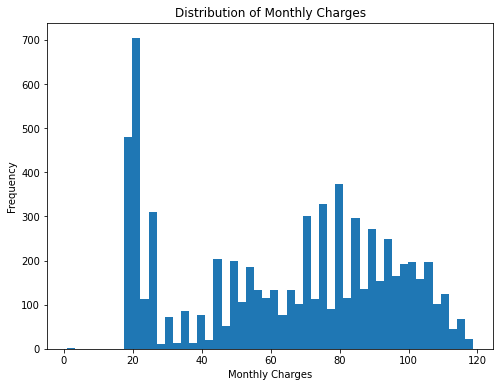

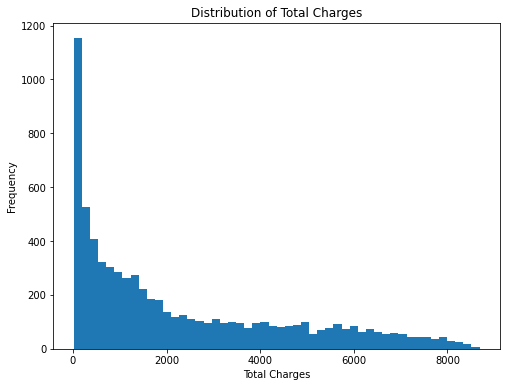

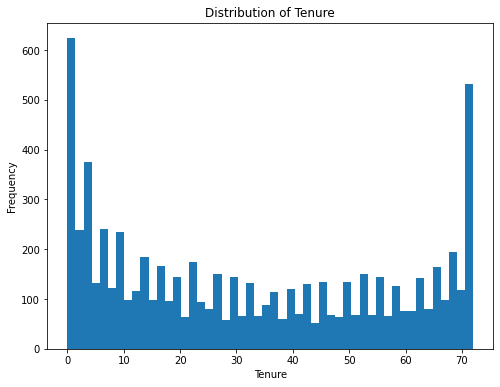

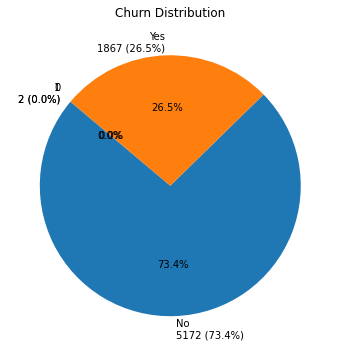

Null Counts:
+------------------+--------------+
| Column           |   Null Count |
+==================+==============+
| customerID       |            0 |
+------------------+--------------+
| gender           |            0 |
+------------------+--------------+
| ZipCode          |         3425 |
+------------------+--------------+
| SeniorCitizen    |            0 |
+------------------+--------------+
| Partner          |            0 |
+------------------+--------------+
| Dependents       |            0 |
+------------------+--------------+
| tenure           |            0 |
+------------------+--------------+
| PhoneService     |            0 |
+------------------+--------------+
| MultipleLines    |            0 |
+------------------+--------------+
| InternetService  |            0 |
+------------------+--------------+
| OnlineSecurity   |            0 |
+------------------+--------------+
| OnlineBackup     |            0 |
+------------------+--------------+
| DeviceProtect

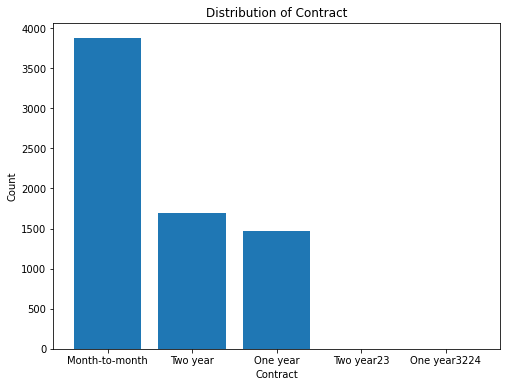

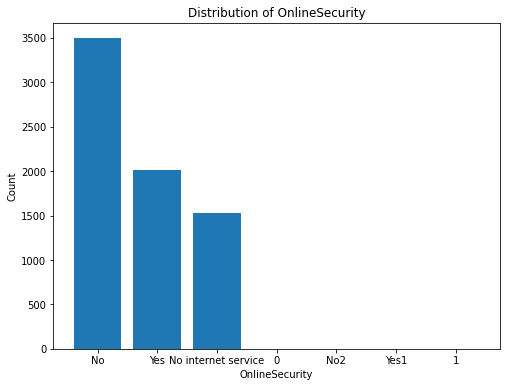

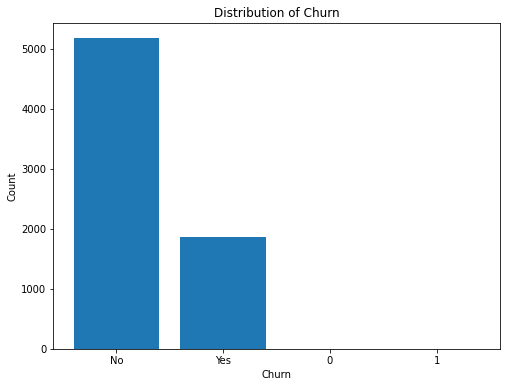

In [6]:
from pyspark.sql.functions import count, when
%pip install tabulate

from tabulate import tabulate

# Plot the distribution of Monthly Charges
monthly_charges = df.select("MonthlyCharges").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.hist(monthly_charges, bins=50)
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Charges')
plt.show()

# Plot the distribution of Total Charges
total_charges = df.select("TotalCharges").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.hist(total_charges, bins=50)
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Total Charges')
plt.show()

# Plot the distribution of Tenure
tenure = df.select("tenure").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.hist(tenure, bins=50)
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.title('Distribution of Tenure')
plt.show()

# Plot the pie chart for Churn
churn_counts = df.groupBy("Churn").count().orderBy("count", ascending=False).collect()
labels = [row['Churn'] for row in churn_counts]
sizes = [row['count'] for row in churn_counts]
total = sum(sizes)
labels_with_counts = [f'{label}\n{count} ({count/total:.1%})' for label, count in zip(labels, sizes)]
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Churn Distribution')
plt.show()

# Count null values in each column and display in a table
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()
null_counts_dict = null_counts[0].asDict()
null_data = [[col, null_counts_dict[col]] for col in df.columns]
print("Null Counts:")
print(tabulate(null_data, headers=["Column", "Null Count"], tablefmt="grid"))



# Compute descriptive statistics for the selected columns
selected_columns = ["ZipCode", "SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
df_selected = df.select(selected_columns)
desc_stats = df_selected.describe().collect()
desc_headers = desc_stats[0].asDict().keys()
desc_data = [row.asDict().values() for row in desc_stats]
print("Descriptive Statistics:")
print(tabulate(desc_data, headers=desc_headers, tablefmt="grid"))

# Plot bar charts for Contract, OnlineSecurity, and Churn
def plot_bar_chart(column_name):
    counts = df.groupBy(column_name).count().orderBy("count", ascending=False).collect()
    labels = [row[column_name] for row in counts]
    values = [row['count'] for row in counts]
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name}')
    plt.show()

plot_bar_chart("Contract")
plot_bar_chart("OnlineSecurity")
plot_bar_chart("Churn")

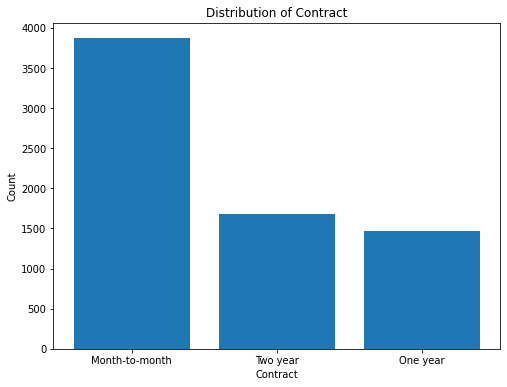

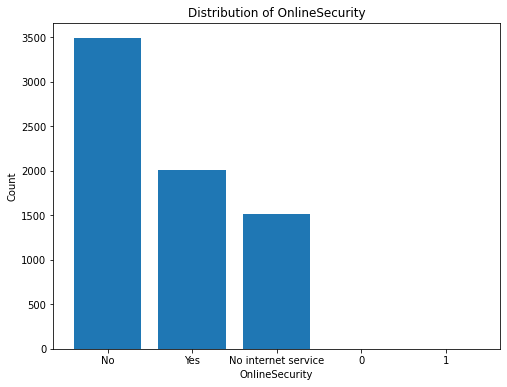

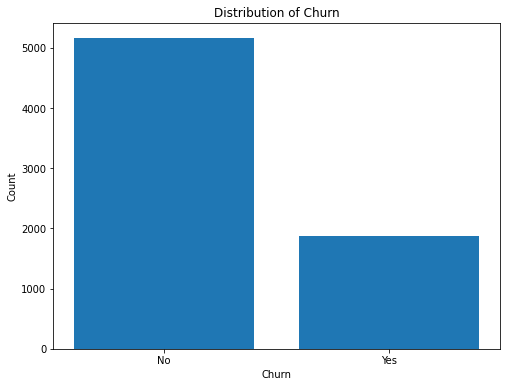

Null Counts:
+------------------+--------------+
| Column           |   Null Count |
+==================+==============+
| Dependents       |            0 |
+------------------+--------------+
| tenure           |            0 |
+------------------+--------------+
| PhoneService     |            0 |
+------------------+--------------+
| MultipleLines    |            0 |
+------------------+--------------+
| InternetService  |            0 |
+------------------+--------------+
| OnlineSecurity   |            0 |
+------------------+--------------+
| OnlineBackup     |            0 |
+------------------+--------------+
| DeviceProtection |            0 |
+------------------+--------------+
| TechSupport      |            0 |
+------------------+--------------+
| StreamingTV      |            0 |
+------------------+--------------+
| StreamingMovies  |            0 |
+------------------+--------------+
| Contract         |            0 |
+------------------+--------------+
| PaperlessBill

+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+-----------------+-----------+
|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|TotalServicesUsed|TenureGroup|
+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+-----------------+-----------+
|         0|  34.0|           1|            0|              0|             1|           0|               1|          0|          0|              0|       1|               0|            2|         56.95|      1889.5|    0|                2|     

,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalServicesUsed,TenureGroup
0,0,34.0,1,0,0,1,0,1,0,0,0,1,0.0,2,56.95,1889.50,0,2,2
1,0,2.0,1,0,0,1,1,0,0,0,0,0,1.0,2,53.85,108.15,1,2,0
2,0,45.0,0,0,0,1,0,1,1,0,0,1,0.0,3,42.30,1840.75,0,3,3
3,0,2.0,1,0,0,0,0,0,0,0,0,0,1.0,1,70.70,151.65,1,0,0
4,0,8.0,1,1,0,0,0,1,0,1,1,0,1.0,1,99.65,820.50,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5927,0,72.0,1,0,0,0,0,0,0,0,0,2,1.0,3,21.15,1419.40,0,0,5
5928,1,24.0,1,1,0,1,0,1,1,1,1,1,1.0,2,84.80,1990.50,0,5,1
5929,1,11.0,0,0,0,1,0,0,0,0,0,0,1.0,1,29.60,346.45,0,1,0
5930,0,4.0,1,1,0,0,0,0,0,0,0,0,1.0,2,74.40,306.60,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5932 entries, 0 to 5931
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dependents         5932 non-null   int32  
 1   tenure             5932 non-null   float64
 2   PhoneService       5932 non-null   int32  
 3   MultipleLines      5932 non-null   int32  
 4   InternetService    5932 non-null   int32  
 5   OnlineSecurity     5932 non-null   int32  
 6   OnlineBackup       5932 non-null   int32  
 7   DeviceProtection   5932 non-null   int32  
 8   TechSupport        5932 non-null   int32  
 9   StreamingTV        5932 non-null   int32  
 10  StreamingMovies    5932 non-null   int32  
 11  Contract           5932 non-null   int32  
 12  PaperlessBilling   5928 non-null   float64
 13  PaymentMethod      5932 non-null   int32  
 14  MonthlyCharges     5932 non-null   float64
 15  TotalCharges       5932 non-null   float64
 16  Churn              5932 

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

# Dropping specific columns
columns_to_drop = ['ZipCode', 'customerID', 'gender', 'SeniorCitizen', 'Partner']
df_cleaned = df.drop(*columns_to_drop)

# Define a function to check if a value is blank or null
def is_blank_or_null(column):
    return (col(column).isNull()) | (col(column) == "") | (col(column).rlike(r'^\s*$'))

# Filter the dataset based on the given conditions
df_cleaned = df_cleaned.filter(
    ~is_blank_or_null('DeviceProtection') &
    ~is_blank_or_null('TechSupport') &
    ~col('TotalCharges').isNull() &
    ~col('MonthlyCharges').isNull()
)

# Correcting inconsistencies in relevant columns
df_cleaned = df_cleaned.withColumn('Churn', when(col('Churn') == 1, 'Yes').otherwise(when(col('Churn') == 0, 'No').otherwise(col('Churn'))))
df_cleaned = df_cleaned.withColumn('OnlineSecurity', when(col('OnlineSecurity') == 'Yes1', 'Yes').when(col('OnlineSecurity') == 'No2', 'No').otherwise(col('OnlineSecurity')))
df_cleaned = df_cleaned.withColumn('PaymentMethod', when(col('PaymentMethod') == 'Electronic check111', 'Electronic check')
                                    .when(col('PaymentMethod') == 'Bank transfer (automatic)222', 'Bank transfer (automatic)').otherwise(col('PaymentMethod')))
df_cleaned = df_cleaned.withColumn('Contract', when(col('Contract') == 'One year3224', 'One year').when(col('Contract') == 'Two year23', 'Two year').otherwise(col('Contract')))


# Plot bar charts for Contract, OnlineSecurity, and Churn
def plot_bar_chart(df_cleaned, column):
    counts = df_cleaned.groupBy(column).count().orderBy("count", ascending=False).collect()
    labels = [row[column] for row in counts]
    values = [row['count'] for row in counts]
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column}')
    plt.show()

plot_bar_chart(df_cleaned, 'Contract')
plot_bar_chart(df_cleaned, 'OnlineSecurity')
plot_bar_chart(df_cleaned, 'Churn')

# Count null values in each column and display in a table
null_counts = df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).collect()
null_counts_dict = null_counts[0].asDict()
null_data = [[col, null_counts_dict[col]] for col in df_cleaned.columns]
print("Null Counts:")
print(tabulate(null_data, headers=["Column", "Null Count"], tablefmt="grid"))

# Determine the 10th and 90th percentile thresholds for `MonthlyCharges` and `TotalCharges`
monthly_charges_lower = df_cleaned.approxQuantile("MonthlyCharges", [0.05], 0.0)[0]
monthly_charges_upper = df_cleaned.approxQuantile("MonthlyCharges", [0.95], 0.0)[0]
total_charges_lower = df_cleaned.approxQuantile("TotalCharges", [0.05], 0.0)[0]
total_charges_upper = df_cleaned.approxQuantile("TotalCharges", [0.95], 0.0)[0]

# Filtering out rows outside these thresholds
df_cleaned = df_cleaned.filter(
    (col('MonthlyCharges') >= monthly_charges_lower) & (col('MonthlyCharges') <= monthly_charges_upper) &
    (col('TotalCharges') >= total_charges_lower) & (col('TotalCharges') <= total_charges_upper)
)

# Define columns representing individual services
service_columns = [
    'InternetService', 'StreamingTV', 'StreamingMovies', 
    'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity'
]

# Converting these columns to binary indicators (1 if 'Yes', 0 if 'No')
for col_name in service_columns:
    df_cleaned = df_cleaned.withColumn(col_name, when(col(col_name) == 'Yes', 1).otherwise(0))

# Create a new feature for total services used
df_cleaned = df_cleaned.withColumn('TotalServicesUsed', sum([col(c) for c in service_columns]))

# Define a function to group tenure
def tenure_group(tenure):
    if tenure <= 12:
        return 0
    elif tenure <= 24:
        return 1
    elif tenure <= 36:
        return 2
    elif tenure <= 48:
        return 3
    elif tenure <= 60:
        return 4
    else:
        return 5

# Apply the function to create a new column for tenure grouping
tenure_group_udf = F.udf(tenure_group, IntegerType())
df_cleaned = df_cleaned.withColumn('TenureGroup', tenure_group_udf(col('tenure')))

# Load the split datasets from Excel files
data_part1 = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('WA_Fn-UseC_-Telco-Customer-Churn-dirty.xlsx')

data_part2 = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('WA_Fn-UseC_-Telco-Customer-Churn-dirty2.xlsx')


data_part1 = data_part1.withColumn("row_id", F.monotonically_increasing_id())
data_part2 = data_part2.withColumn("row_id", F.monotonically_increasing_id())
# Join the DataFrames on the row index
merged_data = data_part1.join(data_part2, on="row_id", how="inner").drop("row_id")
data_part1.drop("row_id")
data_part2.drop("row_id")

# Show the number of rows and columns for each DataFrame
print("data_part1: Rows = {}, Columns = {}".format(data_part1.count(), len(data_part1.columns)))
print("data_part2: Rows = {}, Columns = {}".format(data_part2.count(), len(data_part2.columns)))
print("merged_data: Rows = {}, Columns = {}".format(merged_data.count(), len(merged_data.columns)))

# Define label mapping for categorical columns
label_mapping = {
    'No': 0,
    'Yes': 1,
    'No internet service': 0,
    'DSL': 1,
    'Fiber optic': 2,
    'Electronic check': 1,
    'Mailed check': 2,
    'Bank transfer (automatic)': 3,
    'Credit card (automatic)': 4,
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2,
    'No phone service': 0  # Added mapping for MultipleLines
}

# Function to map categorical values to numerical labels
def safe_map(value, mapping):
    return mapping.get(value, value)

safe_map_udf = F.udf(lambda x: safe_map(x, label_mapping), IntegerType())

# Apply safe_map to relevant columns and cast to IntegerType
df_cleaned = df_cleaned.withColumn('Churn', safe_map_udf(col('Churn')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('PaymentMethod', safe_map_udf(col('PaymentMethod')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('Dependents', safe_map_udf(col('Dependents')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('PhoneService', safe_map_udf(col('PhoneService')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('MultipleLines', safe_map_udf(col('MultipleLines')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('Contract', safe_map_udf(col('Contract')).cast(IntegerType()))
df_cleaned = df_cleaned.withColumn('PaperlessBilling', safe_map_udf(col('PaperlessBilling')).cast(IntegerType()))

# Show the cleaned DataFrame
df_cleaned.show()

# Convert to pandas DataFrame for better display
pandas_df_cleaned = df_cleaned.toPandas()

# Display the pandas DataFrame
display(pandas_df_cleaned)
pandas_df_cleaned.info()

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Chi-square test results for categorical features:
Feature: PaymentMethod, P-value: 0.0000
Feature: TenureGroup, P-value: 0.0000
Feature: StreamingTV, P-value: 0.0000
Feature: StreamingMovies, P-value: 0.0000
Feature: TechSupport, P-value: 0.0000
Feature: DeviceProtection, P-value: 0.0692
Feature: OnlineBackup, P-value: 0.0014
Feature: OnlineSecurity, P-value: 0.0000
Feature: Dependents, P-value: 0.0000
Feature: PhoneService, P-value: 0.0000
Feature: MultipleLines, P-value: 0.0000
Feature: Contract, P-value: 0.0000
Feature: PaperlessBilling, P-value: 0.0000
Correlation matrix:
                      tenure  MonthlyCharges  TotalCharges  TotalServicesUsed  \
tenure             1.000000        0.054642      0.814761           0.393645   
MonthlyCharges     0.054642        1.000000      0.528828           0.620177   
TotalCharges       0.814761        0.528828      1.000000           0.660283   
TotalServicesUsed  0.393645        0.620177      0.660283           1.000000   
Churn           

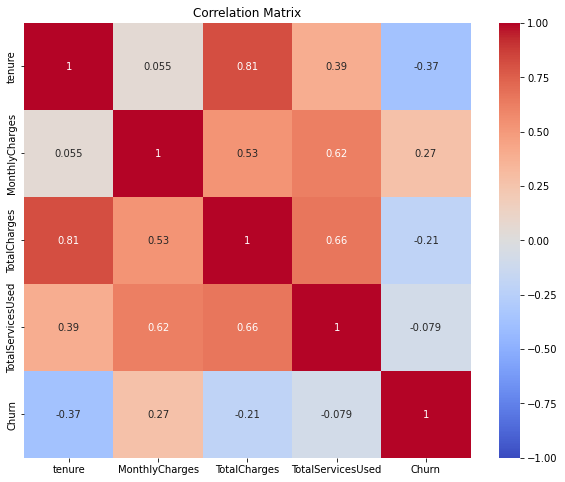

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log1p
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np

# Selecting all relevant columns
categorical_features = ['InternetService', 'PaymentMethod', 'TenureGroup', 'StreamingTV', 
                        'StreamingMovies', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 
                        'OnlineSecurity', 'Dependents', 'PhoneService', 'MultipleLines', 
                        'Contract', 'PaperlessBilling']
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServicesUsed']

# Identify columns with at least two distinct values
valid_categorical_features = [col for col in categorical_features if df_cleaned.select(col).distinct().count() > 1]

# One-hot encoding for categorical features with handleInvalid='skip'
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid='skip').fit(df_cleaned) for column in valid_categorical_features]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_ohe") for column in valid_categorical_features]

# Assemble feature vectors
assembler = VectorAssembler(inputCols=[column+"_ohe" for column in valid_categorical_features] + numeric_features, outputCol="features")

# Pipeline for transformations
pipeline = Pipeline(stages=indexers + encoders + [assembler])
df_transformed = pipeline.fit(df_cleaned).transform(df_cleaned)

# Chi-square test for categorical features
chi_square_results = ChiSquareTest.test(df_transformed, "features", "Churn").head()
print("Chi-square test results for categorical features:")
for feature, p_val in zip(valid_categorical_features, chi_square_results.pValues):
    print(f"Feature: {feature}, P-value: {p_val:.4f}")

# Correlation matrix for numeric features
numeric_data = df_cleaned.select(numeric_features + ['Churn']).toPandas()
corr_matrix = numeric_data.corr()

# Display correlation matrix
print("Correlation matrix:\n", corr_matrix)

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()




In [10]:
%pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# Define the features and target
X = pandas_df_cleaned.drop(columns=['Churn'])
Y = pandas_df_cleaned['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Feature importances
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display feature importances
print("Feature Importances:\n", feature_importances)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Feature Importances:
 MonthlyCharges       0.221587
TotalCharges         0.191358
tenure               0.155144
Contract             0.084985
PaymentMethod        0.063794
TenureGroup          0.047129
TotalServicesUsed    0.042471
PaperlessBilling     0.027096
MultipleLines        0.021820
TechSupport          0.021397
Dependents           0.021284
OnlineSecurity       0.020909
OnlineBackup         0.019980
DeviceProtection     0.018793
StreamingMovies      0.017760
StreamingTV          0.017416
PhoneService         0.007077
InternetService      0.000000
dtype: float64


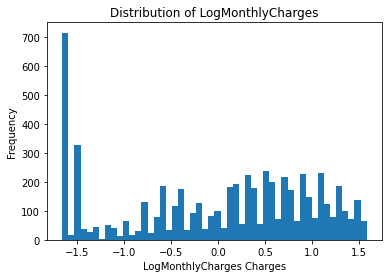

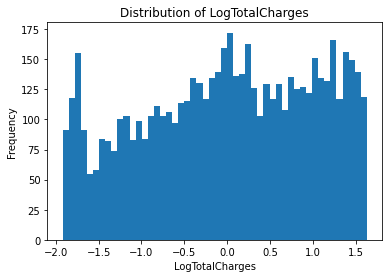

In [11]:
# Drop less important columns
columns_to_drop = ['Dependents', 'TotalServicesUsed','PhoneService', 'InternetService']
df_cleaned = df_cleaned.drop(*columns_to_drop)

# Log transformation for skewed features
df_cleaned = df_cleaned.withColumn('LogTotalCharges', log1p(col('TotalCharges')))
df_cleaned = df_cleaned.withColumn('LogMonthlyCharges', log1p(col('MonthlyCharges')))

# Standardize numeric features
assembler = VectorAssembler(inputCols=['LogTotalCharges', 'LogMonthlyCharges'], outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
pipeline = Pipeline(stages=[assembler, scaler])
df_scaled = pipeline.fit(df_cleaned).transform(df_cleaned)

# Convert to pandas DataFrame for plotting
pandas_df_cleaned = df_cleaned.select('LogTotalCharges', 'LogMonthlyCharges').toPandas()

# Applying Box-Cox transformation
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox')
pandas_df_cleaned[['LogTotalCharges', 'LogMonthlyCharges']] = pt.fit_transform(pandas_df_cleaned[['LogTotalCharges', 'LogMonthlyCharges']])

# Plot histograms
pandas_df_cleaned['LogMonthlyCharges'].plot.hist(bins=50)
plt.xlabel('LogMonthlyCharges Charges')
plt.ylabel('Frequency')
plt.title('Distribution of LogMonthlyCharges')
plt.show()

pandas_df_cleaned['LogTotalCharges'].plot.hist(bins=50)
plt.xlabel('LogTotalCharges')
plt.ylabel('Frequency')
plt.title('Distribution of LogTotalCharges')
plt.show()
